In [2]:
import numpy as np
import scipy.stats
import pylab as plt
from matplotlib import pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import random
import math

In [3]:
!pip install emcee
import emcee

!pip install corner
import corner

First, we define our model, the likelihood, the priors and the posterior. In particular, emcee wants the $\ln(posterior)$.

In [4]:
# p = [b,A,t0,alpha]  parameters vector

def model(p,x):  #model for the burst
    array = np.full_like(x,1)
    array[x<p[2]] = p[0]
    array[x>=p[2]] = p[0]+p[1]*np.exp(-p[3]*(x[x>=p[2]]-p[2]))
    return array

def log_likelihood(p,x,y,yerr):
    return -0.5*np.sum((y-model(p,x))**2/yerr**2+np.log(2*np.pi*yerr**2))

def prior(p):
    if p[3]<0:
        return 0
    prior_b = stats.uniform.pdf(p[0],loc=0,scale=50) #uniform distribution [0,50]
    prior_A = stats.uniform.pdf(p[1],loc=0,scale=50) #uniform distribution [0,50]
    prior_t0 = stats.uniform.pdf(p[2],loc=0,scale=100) #uniform distribution [0,100]
    #ln(alpha) uniform distribution [-5,5] --> p(alpha) = p(ln_alpha)/(alpha)
    prior_alpha = stats.uniform.pdf(np.log(p[3]),loc=-5,scale=10)/(p[3])
    if prior_b*prior_A*prior_t0*prior_alpha==0:
        return 0
    else:
        return prior_b*prior_A*prior_t0*prior_alpha

def log_posterior(p,x,y,yerr): # posterior proportional to (Likelihood x Prior)
    lp = np.log(prior(p))
    ll = log_likelihood(p,x,y,yerr)
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(ll):
        return -np.inf
    else:
        return ll+lp

Then, we load and plot our data.

In [5]:
data = np.load('transient.npy')

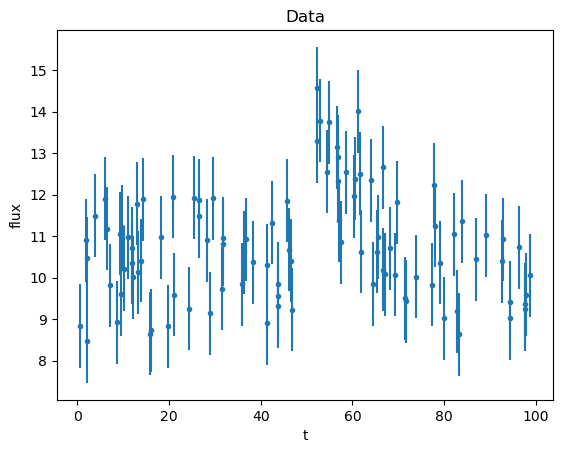

In [6]:
plt.errorbar(data[:,0],data[:,1],data[:,2],fmt='.')
plt.xlabel('t')
plt.ylabel('flux')
plt.title('Data')
plt.show()

Now, we use emcee to build a chain of samples of the posterior of the four parameters.

In [20]:
ndim = 4  # number of parameters in the model
nwalkers = 8  # number of MCMC walkers
nsteps = 90000 # number of steps

starting_guesses = np.array([10,50,5,0.12])+1e-3*np.random.random((nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,args=[data[:,0],data[:,1],data[:,2]])
sampler.run_mcmc(starting_guesses, nsteps)  #iterate nsteps times

C:\Users\giuli\AppData\Local\Temp\ipykernel_13900\209118803.py:26: RuntimeWarning: divide by zero encountered in log
  lp = np.log(prior(p))
C:\Users\giuli\AppData\Local\Temp\ipykernel_13900\209118803.py:10: RuntimeWarning: overflow encountered in square
  return -0.5*np.sum((y-model(p,x))**2/yerr**2+np.log(2*np.pi*yerr**2))
C:\Users\giuli\AppData\Local\Temp\ipykernel_13900\209118803.py:6: RuntimeWarning: overflow encountered in exp
  array[x>=p[2]] = p[0]+p[1]*np.exp(-p[3]*(x[x>=p[2]]-p[2]))
C:\Users\giuli\AppData\Local\Temp\ipykernel_13900\209118803.py:6: RuntimeWarning: overflow encountered in multiply
  array[x>=p[2]] = p[0]+p[1]*np.exp(-p[3]*(x[x>=p[2]]-p[2]))


State([[10.11289286  4.1180172  49.8781293   0.09497996]
 [10.20154087  8.5492952  47.43263861  0.14001709]
 [10.57985728  4.52524411 50.5941426   0.17317323]
 [10.05728685  5.03114372 50.76173943  0.10046982]
 [10.26830091  7.73170754 47.70541294  0.1395244 ]
 [10.2956889   4.77022551 49.89117838  0.14055168]
 [10.15398047  4.7490659  49.68333795  0.10873681]
 [10.23757773  6.95456461 47.63321866  0.11798186]], log_prob=[-154.97289481 -154.43585348 -157.37136159 -155.54568213 -153.83227184
 -154.77926045 -154.03492585 -153.45271853], blobs=None, random_state=('MT19937', array([3681610460,  759919854, 2426426244, 1170489492, 2015891821,
       4288338685, 4164666247, 1516616825,  421840783, 3439757125,
       2037811339,   53885202,  911717180, 4001298445, 3679281090,
       1217861787,  984089532, 2684963300, 2970665451,  241517577,
        462486629, 4060408545, 4256381772,  465787504,  876371039,
       4153426795, 2057940149, 1601576172, 3163961090, 3827291679,
       4085085255, 2

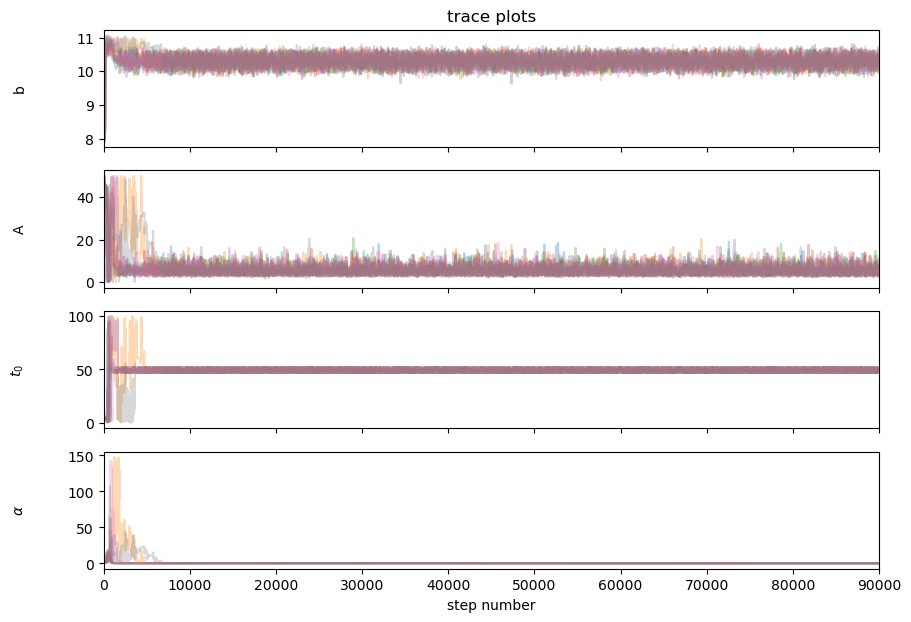

In [21]:
labels = ['b','A',r"$t_0$",r"$\alpha$"]

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
sampler_plot = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler_plot[:, :, i], alpha=0.3)
    ax.set_xlim(0, len(sampler_plot))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
axes[0].set_title('trace plots')
plt.show()

Let's compute the autocorrelation time to thin our data. Moreover, we discard the initial burn-in.

In [22]:
autocorr = sampler.get_autocorr_time() #to get the autocorrelation time
autocorr

array([ 272.33592658, 1526.31485513,  465.03626236, 1253.51337135])

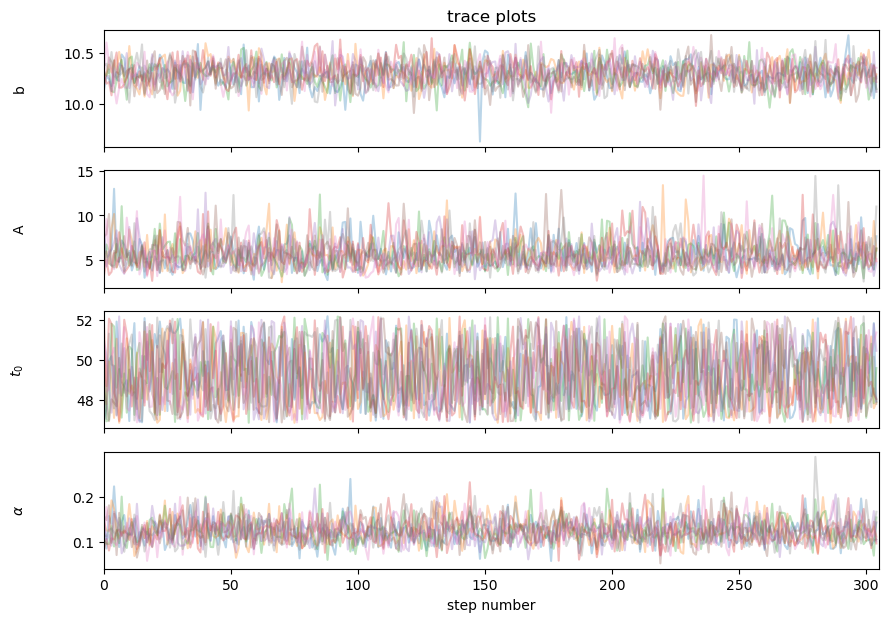

In [35]:
burn = 6800  # "burn-in" period
thin = int(np.min(autocorr))

fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
plot_sampler = sampler.get_chain(discard=burn, thin=thin)

for i in range(ndim):
    ax = axes[i]
    ax.plot(plot_sampler[:,:,i], alpha=0.3)
    ax.set_xlim(0, len(plot_sampler))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
axes[0].set_title('trace plots')
plt.show()

We compute the median for each of the chains: these will be the estimated true values of the four parameters.

In [30]:
medians = []
for i in range(ndim):
    medians.append(np.median(sampler_plot[:,:,i]))

We make corner plots, first with a $95\%$ credible region, then $68\%$.

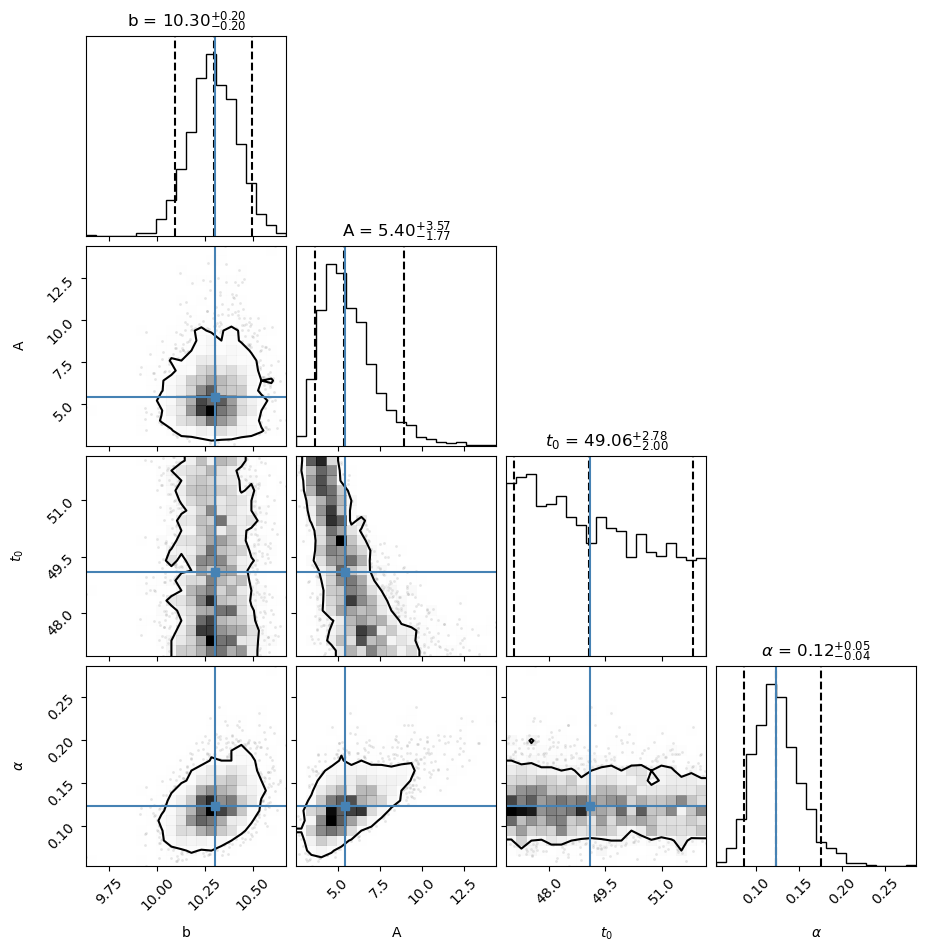

In [31]:
plot_sampler = sampler.get_chain(discard=burn,thin=thin,flat=True)
fig = corner.corner(plot_sampler, levels=[0.9],labels=labels,
                    truths=medians,show_titles=True,quantiles=[0.05,0.5,0.95])

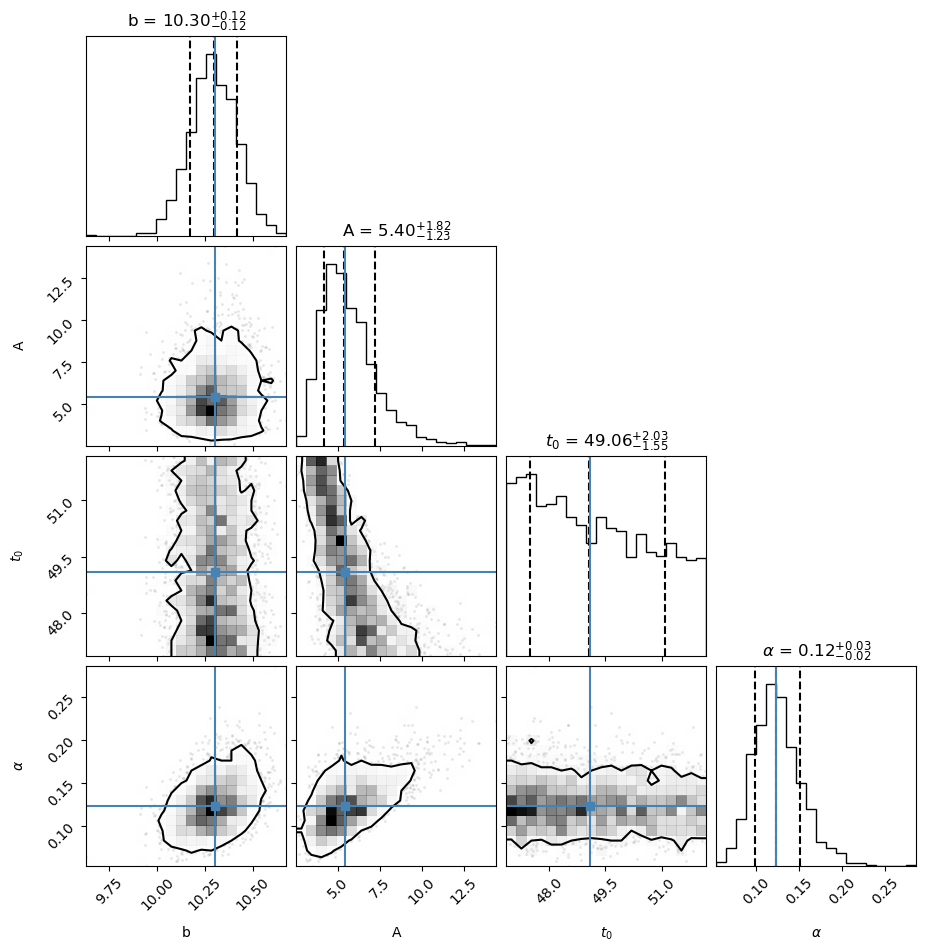

In [32]:
plot_sampler = sampler.get_chain(discard=burn,thin=thin,flat=True)
fig = corner.corner(plot_sampler, levels=[0.9],labels=labels,
                    truths=medians,show_titles=True,quantiles=[0.16,0.5,0.84])

Now, we choose 100 random samples from the burned, thinned chain and overplot to the data the 100 corresponding burst-models.

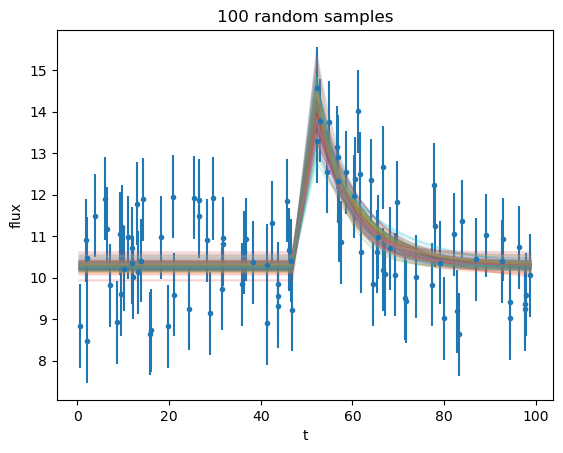

In [69]:
plt.errorbar(data[:,0],data[:,1],data[:,2],fmt='.')

for i,j in zip(np.random.randint(0,plot_sampler.shape[0]-1,size=100),np.random.randint(0,plot_sampler.shape[1]-1,size=100)):
    plt.plot(data[:,0],model(plot_sampler[i,j],data[:,0]),'-',alpha =0.2)

plt.xlabel('t')
plt.ylabel('flux')
plt.title('100 random samples')
plt.show()

Lastly, we plot the burst-model using the previously computed medians.

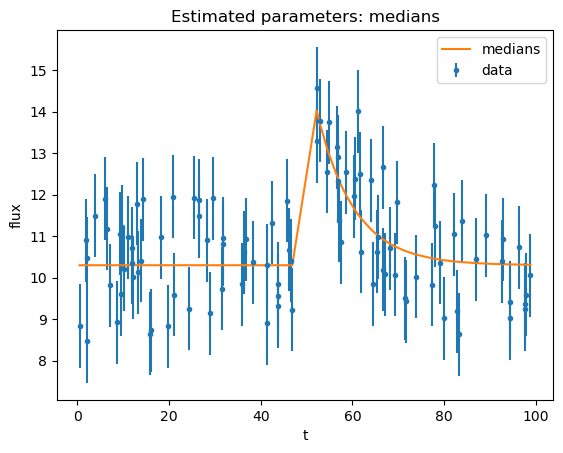

In [34]:
plt.errorbar(data[:,0],data[:,1],data[:,2],fmt='.',label='data')
plt.plot(data[:,0],model(medians,data[:,0]),'-',label='medians')
plt.xlabel('t')
plt.ylabel('flux')
plt.legend()
plt.title('Estimated parameters: medians')
plt.show()